# Практическое ДЗ 1. Удаление фона с помощью SVD

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.


**Замечание: далее пользоваться циклами запрещено, если это явно не прописано в задании. Вместо этого используйте функции numpy.**

In [1]:
%pip install -q moviepy --upgrade
%pip install -q ffmpeg --upgrade


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("data/SVD_video_1.mp4")
video.ipython_display(width=300, maxduration=250)

RuntimeError: No ffmpeg exe could be found. Install ffmpeg on your system, or set the IMAGEIO_FFMPEG_EXE environment variable.

Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
video.fps

23.976023976023978

In [60]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_h, size_w = video.size
    arr = np.zeros([nframes, size_w, size_h])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 60 x 80, 
number of frames: 2883


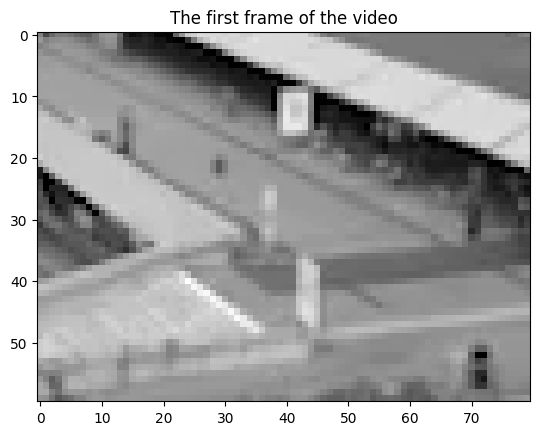

In [61]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

### a. Применение базового алгоритма SVD (30 баллов)

1. **(10 балла)** С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерный массив ```M``` размера ```(size_h * size_w) x nframes```, каждым столбцом которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

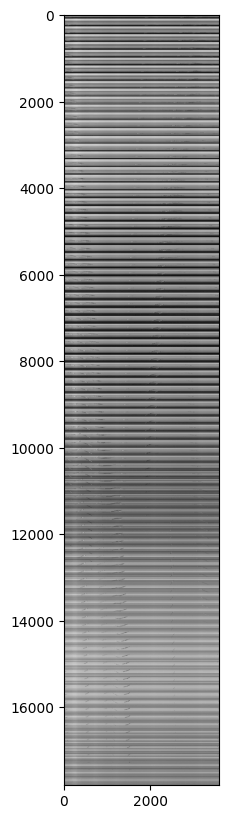

In [142]:
nframes, size_w, size_h = arr.shape
M = arr.reshape((nframes, size_w * size_h)).transpose()

plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray');

Если всё сделано правильно, то вы сможете восстановить первый кадр из первого столбца:

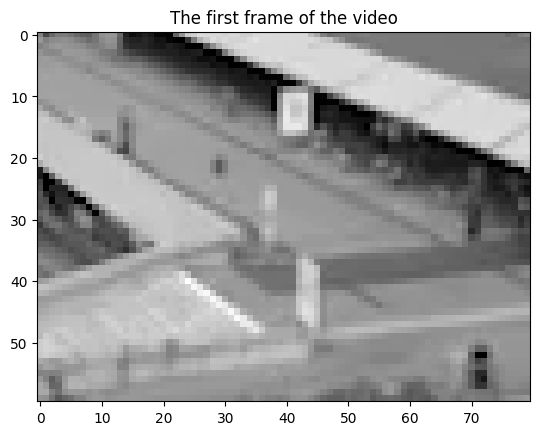

In [13]:
first_frame = M[:,0].reshape((size_w, size_h)) # TO BE FILLED
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video')

2. **(6 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Постройте график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных. 

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел. Не забывайте подписывать оси!

In [17]:
U, S, VT = np.linalg.svd(M, full_matrices=False)

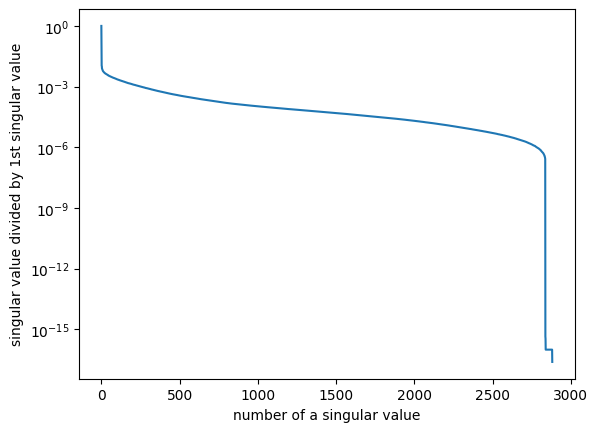

In [21]:
plt.semilogy(S / S[0])
plt.xlabel("number of a singular value")
plt.ylabel("singular value divided by 1st singular value")
plt.show()

In [23]:
print(S.shape)

(2883,)


Первое сингулярное значение показывает направление, по которому мы имеем наилучшее одноранговое приближение "матрицы", т.е. фон видео в этом случае. Несколько наименьших сингулярных чисел настолько сильно отличаются от других, т.к. они близки к "машинному эпсилону" и скачки абсолютных величин тут особенно остро можно заметить

3. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в фробениусовой норме, т.е. $$
\frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для расчета относительной точности используйте **только** сингулярные числа матрицы $M$. 

In [76]:
def trunc_svd(M, r):
    U, S, VT = np.linalg.svd(M, full_matrices=False)
    norm2 = np.linalg.norm(S)
    S[r:] = 0
    norm1 = np.linalg.norm(S)
    return U @ np.diag(S) @ VT, norm1 / norm2
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            
        Output
            Mr: 2D numpy array of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''

4. **(4 балла)** Используя написанную функцию, найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [81]:
M_approx, error_deter = trunc_svd(M, 1)
first_frame_approx = M_approx[:,0].reshape((size_w, size_h))

ValueError: cannot reshape array of size 4800 into shape (100,178)

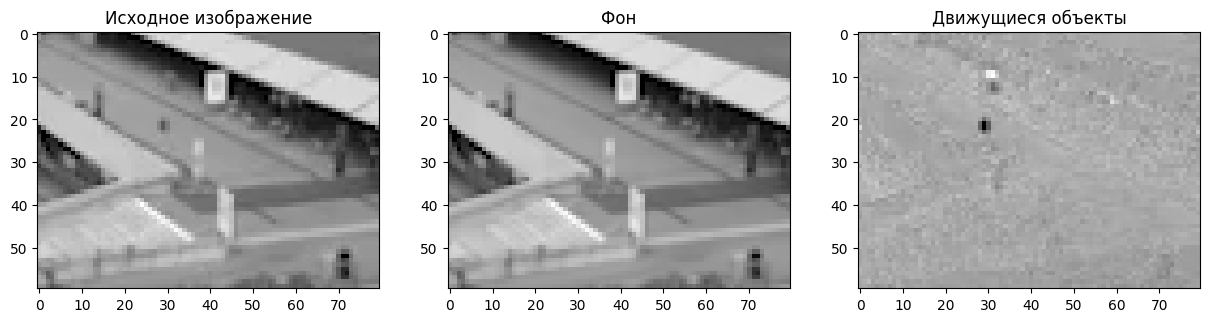

In [28]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame, cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(first_frame_approx, cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(first_frame - first_frame_approx, cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

### b. Применение рандомизированного алгоритма SVD (28 баллов)

Загрузим теперь видео в более высоком разрешении.

In [64]:
import moviepy.editor as mpe
video3 = mpe.VideoFileClip("data/SVD_video_3.mp4", target_resolution=(100, 178))
video3.ipython_display(width=300, maxduration=250)
arr = video_to_array(video3)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
image size: 100 x 178, 
number of frames: 3600


In [65]:
arr3 = video_to_array(video3)
nframes, size_w, size_h = arr3.shape
M3 = arr3.reshape((nframes, size_w * size_h)).transpose()

image size: 100 x 178, 
number of frames: 3600


Text(0.5, 1.0, 'The first frame of the video')

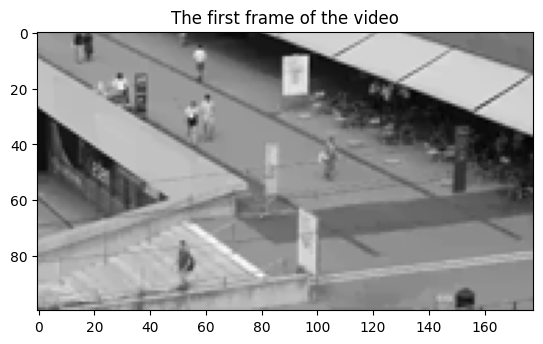

In [33]:
first_frame = M3[:,0].reshape((size_w, size_h)) # TO BE FILLED
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video')

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений (есть также [пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1. **(16 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы не вычисляете в явном виде матрицу $QQ^\top$. Если на заданной матрице алгоритм работает слишком долго (минуты), то возможно, вы что-то делаете не так.

In [39]:
def rand_svd(M, r, oversampling=10):
    rank = r + oversampling
    omega = np.random.randn(M.shape[1], rank)
    im_omega = M @ omega
    Q, R = np.linalg.qr(im_omega)
    U, Sigma, VT = np.linalg.svd(Q.T @ M, full_matrices=False)
    Sigma[r:] = 0
    M_approx = Q @ U @ np.diag(Sigma) @ VT
    return M_approx, np.linalg.norm(M - M_approx) / np.linalg.norm(M)
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            oversampling: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''

2. **(2 балл)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [66]:
M_rand, error_rand = rand_svd(M3, 1)
first_frame_approx = M_rand[:,0].reshape((size_w, size_h))

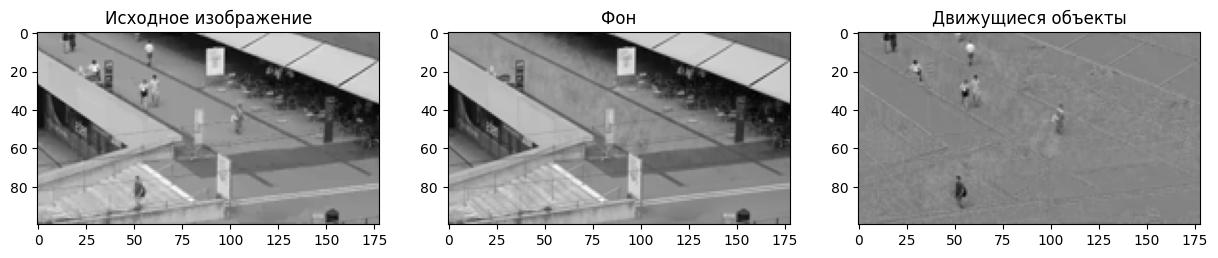

In [41]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame, cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(first_frame_approx, cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(first_frame - first_frame_approx, cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

3. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберите сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу по оси с ошибкой.
**В данном задании разрешается использовать циклы для перебора по сетке и запуска алгоритма 10 раз.**

In [43]:
p = np.linspace(0, 30, 16)
errors = np.zeros((p.shape[0], ))
measures_size = 10
for i, p_i in enumerate(p):
    measures = np.zeros((measures_size, ))
    for j in range(measures_size):
        _, measures[j] = rand_svd(M, 2, int(p_i))
    errors[i] = np.average(measures)
    print(p_i, "done", end='; ')

print()

0.0 done; 2.0 done; 4.0 done; 6.0 done; 8.0 done; 10.0 done; 12.0 done; 14.0 done; 16.0 done; 18.0 done; 20.0 done; 22.0 done; 24.0 done; 26.0 done; 28.0 done; 30.0 done; 


In [ ]:
print(p)

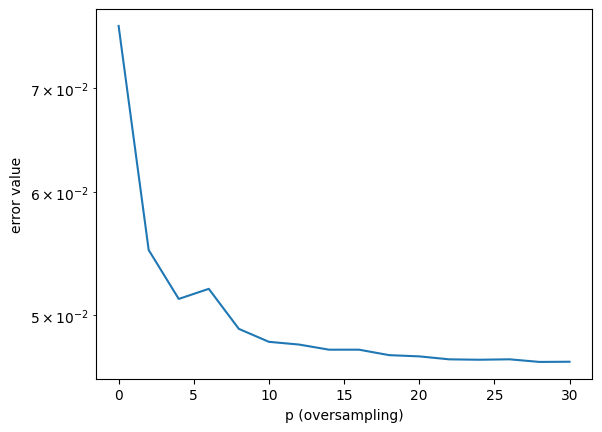

In [46]:
plt.semilogy(p, errors)
plt.xlabel("p (oversampling)")
plt.ylabel("error value")
plt.show()

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгоритм. Также обратите внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может случиться переполнение по памяти. 

### c. Видео с переменным освещением (12 баллов)

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [87]:
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")
video2.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [88]:
arr2 = video_to_array(video2)

image size: 60 x 80, 
number of frames: 2883


Пока что возьмём лишь первые 80% видео, остальной частью воспользуемся позже.

In [89]:
breakpoint = round(0.8*arr2.shape[0])
remaining = arr2[breakpoint:]
arr2 = arr2[:breakpoint]

1. Аналогично пункту a.1) получите из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```(size_h * size_w) x nframes2```.

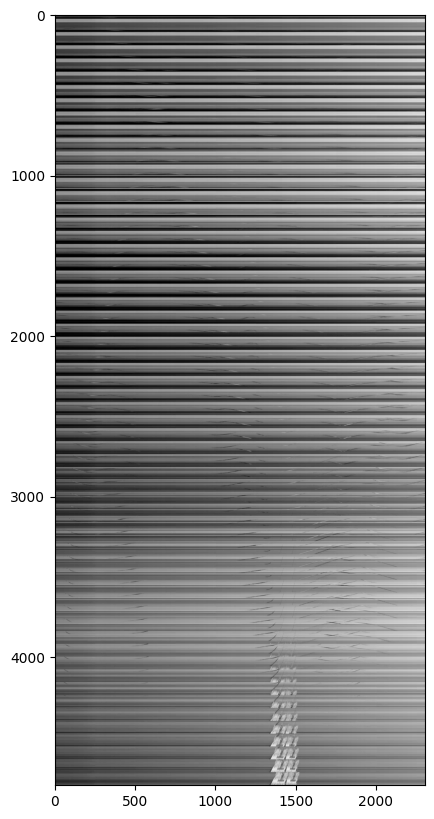

In [90]:
nframes2, size_w, size_h = arr2.shape
M2 = arr2.reshape((nframes2, size_w * size_h)).transpose()

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray');

2. **(3 балла)** Примените методы из пунктов a) и b) (то есть библиотечное полное SVD и рандомизированное SVD) для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`. Сравните время работы алгоритмов.

In [53]:
import time

In [78]:
start = time.time_ns()
M2_svd, error_deter2 = trunc_svd(M2, 2)
t = time.time_ns() - start
print("Deterministic algorithm running time:", t / 1000, "us")

Deterministic algorithm running time: 18576622.0 us


In [79]:
start = time.time_ns()
M2_rand, error_rand2 = rand_svd(M2, 2, 2)
t = time.time_ns() - start
print("Randomized algorithm running time:", t / 1000, "us")

Randomized algorithm running time: 243924.0 us


Детерминированный алгоритм работает на 2-3 порядка медленнее

3. **(4 балла)** Cравните относительные точности таких приближений для настоящего SVD и рандомизированного алгоритма; также сравните их с соответствующей величиной для видео с постоянным освещением. Какие выводы можно сделать?

In [82]:
print("Deterministic algorithm error (constant light):", error_deter)
print("Deterministic algorithm error (variable light):", error_deter2)
print("Randomized algorithm error (variable light):", error_rand2)

Deterministic algorithm error (constant light): 0.9984493042329288
Deterministic algorithm error (variable light): 0.9981601677282984
Randomized algorithm error (variable light): 0.08469442297445795


Видим, что честное 2-приближение М2 схоже (с точки зрения нормы Фробениуса) с честным 2-приближению М1, а вот рандомизированный алгоритм имеет неслабую ошибку

4. **(5 балла)** Заполните пропуски в функции `M_to_video`, преобразующей матрицу типа ```M2``` обратно в видео.

In [84]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[1]
    arr = M.transpose().reshape((nframes, size_w,  size_h)) # YOUR CODE GOES HERE
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)

Посмотрим, как выглядит предлагаемое приближение.

In [92]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Для большей наглядности можете также запустить видео из пункта b) с более высоким разрешением.

### d. Обработка новых кадров (25 баллов)

Предположим, что на камеру поступил новый поток кадров. Мы могли бы увеличить нашу матрицу M2 и пересчитать SVD, но это слишком вычислительно сложно ради нескольких новых кадров. Более того, логично предположить, что если у нас уже было достаточно много кадров в матрице M2, то сингулярные векторы не изменятся сильно от добавления новых кадров.

При этом просто вычесть фон не получится, ведь мы хотим также учитывать изменение освещения. Для этого посчитаем ортогональную проекцию нового кадра на образ матрицы M2.




1. **(15 баллов)** Используя SVD разложение ортогонально спроецируйте новый кадр на образ матрицы M2.

Ваш код должен работать как для 1 кадра (вектора длины size_h * size_w), так и для нескольких (матрицы размера (size_h * size_w) x k). Сложность итогового алгоритма для обработки 1 кадра должна быть O(size_h * size_w). SVD матрицы M2 считайте предпосчитанным. 

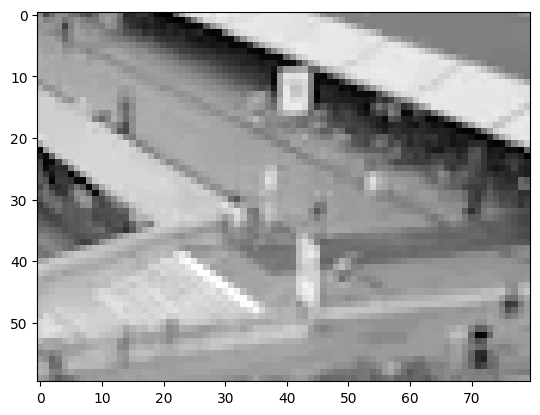

In [93]:
new_frame = remaining[-1].reshape(size_w*size_h)
plt.imshow(new_frame.reshape(size_w, size_h), cmap='gray');

In [114]:
# YOUR CODE GOES HERE (duplicate code from trunc_SVD)
U_2, S_2, VT_2 = np.linalg.svd(M2, full_matrices=False)


In [121]:
S_2 = S_2[:2]
U_2 = U_2[:, :2]
VT_2 = VT_2[:2, :]

In [128]:
def project_new_frames(U, S, VT, new_frames):
    Q, R = np.linalg.qr(np.diag(S) @ VT)
    U_new = U @ Q
    '''
        Input
            U, S, VT: rank r compact SVD of matrix M2 (U @ S @ VT = M2_r)
            new_frames:  vector (size_h * size_w,) or matrix (size_h * size_w x nframes)

        Output
            proj: projection of new frames to Im(M2_r)
    '''
    return U @ U.T @ new_frames

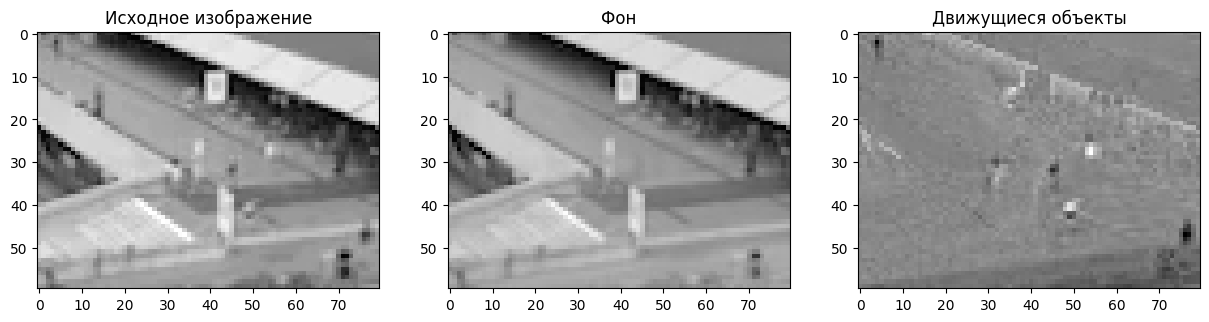

In [129]:
new_frame_proj = project_new_frames(U_2, S_2, VT_2, new_frame)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(new_frame_proj.reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow((new_frame - new_frame_proj).reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

2. **(5 баллов)** Используя [np.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) добавьте кадры из remaining к столбцам M2, чтобы получить матрицу полного видео M_full. Аналогично преобразуйте трехмерный массив remaining в матрицу формате (size_h * size_w x remaining_nframes). Спроецируйте все кадры (столбцы) этой матрицы и преобразуйте матрицу обратно в видео.


In [130]:
remaining_nframes, size_w, size_h = remaining.shape
M_remaining = remaining.reshape((remaining_nframes, size_w * size_h)).transpose()
M_full = np.concatenate((M2, M_remaining), axis=1)

In [131]:
M_proj = project_new_frames(U_2, S_2, VT_2, M_full)

video2_svd = M_to_video(M_full - M_proj, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


3. **(2 балла)** Как говорилось выше, можно сэкономить много ресурсов с помощью рандомизированного SVD алгоритма. Рассмотрите аналогичную ортопроекцию с помощью рандомизированного SVD разложения.

In [132]:
r = 2
oversampling = 10

# YOUR CODE GOES HERE (duplicate code from rand_SVD)

rank = r + oversampling
omega = np.random.randn(M.shape[1], rank)
im_omega = M @ omega
Q, R = np.linalg.qr(im_omega)
U, Sigma, VT = np.linalg.svd(Q.T @ M, full_matrices=False)
S_2_rand = Sigma[:2]
U_2_rand = (Q @ U)[:, :2]
VT_2_rand = VT[:2, :]

In [133]:
M_proj_rand = project_new_frames(U_2_rand, S_2_rand, VT_2_rand, M_full)

video2_svd = M_to_video(M_full - M_proj_rand, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


4. **(3 балла)** Найдите $M_{\text{true}}$ - лучшее приближение 2 ранга матрицы M2_full с помощью честного SVD (аналогично заданию c). Посчитайте относительные точности приближений из пунктов 2 и 3; сравните качество видео. Какие выводы можно сделать по качеству видео и итоговым ошибкам?

$$
    \dfrac{\| M_{\text{true}} - M_{\text{proj}} \|_F}{\| M_{\text{true}} \|_{F}};\quad 
    \dfrac{\| M_{\text{true}} - M_{\text{proj rand}} \|_F}{\| M_{\text{true}} \|_{F}}
$$

In [134]:
M_true = trunc_svd(M_full, 2)[0]

video2_svd = M_to_video(M_full - M_true, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [135]:
error_proj = np.linalg.norm(M_true - M_proj) / np.linalg.norm(M)
error_proj_rand = np.linalg.norm(M_true - M_proj_rand) / np.linalg.norm(M)
print("Deterministic algorithm projection error:", error_proj)
print("Randomized algorithm projection error:", error_proj_rand)

Deterministic algorithm projection error: 0.02020886730729618
Randomized algorithm projection error: 0.06770452016907276


**Выводы:**

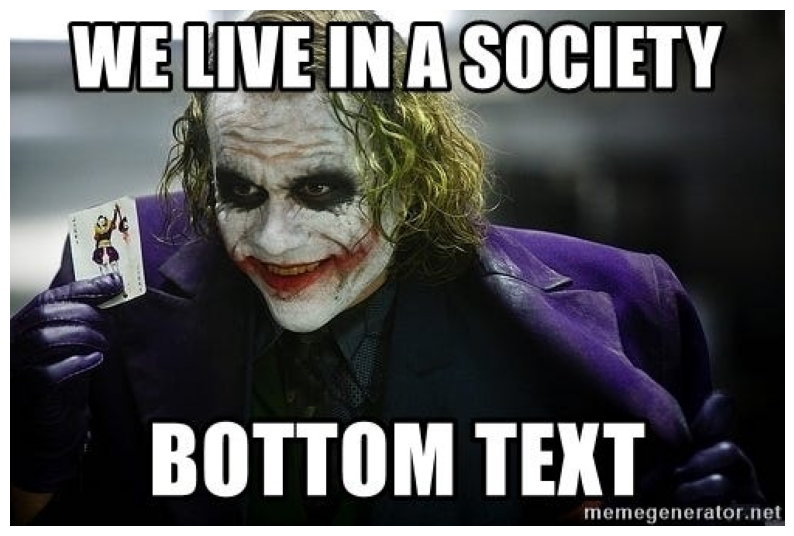

In [137]:
!wget https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F89e07e37-3c88-4724-87ae-b0e6cc12b524_500x333.jpeg -O soci£ety.jpeg -q
image = plt.imread('society.jpeg')
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

### e. Robust PCA (5 баллов)

Заметим, что матрицу $M$ можно приближенно представить в виде $M = L + S$, где $L$ - малоранговая матрица, а $S$ - разреженная (то есть содержащая большое количество нулей). Для поиска $L$ и $S$ мы могли бы попытаться решить задачу

$$
    \mathrm{rank}(L) + \alpha\ \mathrm{nnz}(S) \to \min_{L,S}, \quad \alpha > 0
$$

при ограничении $M = L + S$, где $\mathrm{nnz}(S)$ обозначет число ненулевых элементов (<b>n</b>umber of <b>n</b>on<b>z</b>eros). 
Однако такую задачу решать крайне сложно из-за отсутствия непрерывности и выпуклости. 
Поэтому обычно ее [заменяют на более простую](https://arxiv.org/pdf/0912.3599.pdf):

$$
    \|L\|_* + \alpha \|S\|_{\mathrm{sum}} \to \min_{L, S}, \quad \alpha > 0,
$$

где $\|\cdot\|_*$ обозначает ядерную норму матрицы, а $\|\cdot\|_{\mathrm{sum}}$ является суммой модулей всех элементов матрицы ($\ell_1$-норма).

Для вычисления robust PCA скачаем код по ссылке [https://github.com/dganguli/robust-pca](https://github.com/dganguli/robust-pca) и импортируем его:

In [166]:
# Если вы работаете на windows - скачивайте самостоятельно
!wget https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
import r_pca

--2023-02-10 21:52:32--  https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3105 (3.0K) [text/plain]
Saving to: ‘r_pca.py’

r_pca.py            100%[===================>]   3.03K  --.-KB/s    in 0s      

2023-02-10 21:52:33 (13.2 MB/s) - ‘r_pca.py’ saved [3105/3105]



Мы использовали класс ```R_pca``` и запустили функцию ```fit(max_iter=4000, iter_print=100)``` для нахождения матриц $L$ и $S$ по матрице $M$ из пункта a).

1. **(5 баллов)** С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео,
    - фона,
    - изображения людей.

Обратите внимание, что на исходных данных метод может работать довольно долго (вероятно, часы). Поэтому предлагается взять только четверть временного ряда, а также вырезать каждый второй кадр. Используйте видео с низким разрешением из пункта a).

In [182]:
Mt = M[:,:M.shape[1]//4:2]
print(Mt.shape)

(17800, 450)


In [185]:
print(np.linalg.norm(Mt, ord='fro'))

398986.74881880474


In [187]:
solver = r_pca.R_pca(Mt, mu=0.68) # в нашем случае такой mu работает лучше исходного
L_pca, S_pca = solver.fit(max_iter=4000, iter_print=100)

iteration: 1, error: 8.771394339247115
iteration: 3, error: 0.03804332542983562


(17800, 450)
(17800, 3600)
(178, 100)


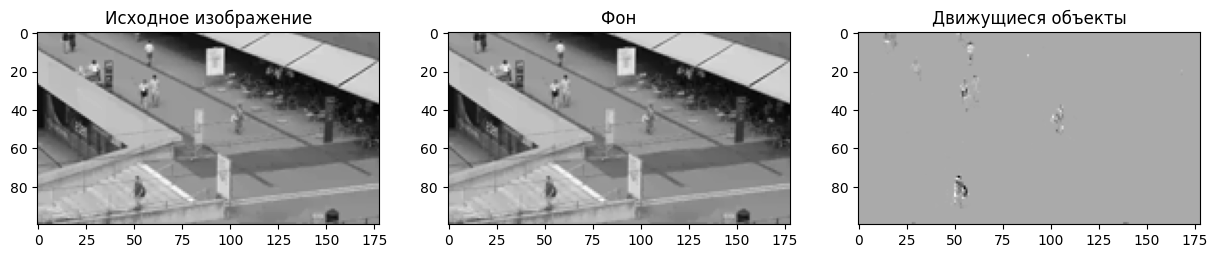

In [188]:
_, axs = plt.subplots(1,3, figsize=(15,10))
print(S.shape)
print(M.shape)
print((size_h, size_w))
axs[0].imshow(M[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(L_pca[:, 0].reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow((S_pca[:, 0]).reshape(size_w, size_h), cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

Аналогично можно посмотреть на видео движущихся объектов:

In [181]:
video_rpca = M_to_video(L_pca, 20, size_w, size_h) # TO BE FILLED
video_rpca.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### f. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.